# Tuto\#5 Build your own model
In this tutorial, we are going to detail the structure of GRIP and how to design your own model.

## The nested structure of GRIP
Throughout the previous tutorials, we have set some lists and tuples which embeds callable functions and their arguments.

GRIP is a tool box, designed to be flexible as a requirement to be compatible with any nulling data.
It is also simulation-based, by using a model of the instrument (also named as null depth estimator) to reproduce sequence of null depths which statistical distribution is compared to the one of the measurements.

It is structured in three layers:
- top: functions calling the fitting algorithm (e.g. likelihood, least squares or MCMC)
- middle: functions calling the cost function (e.g. binomial likelihood, $\chi^2$, posterior) and the builder of the model (namely `grip.create_histogram_model`)
- bottom: the instrument model (e.g. `grip.lbti_model`).

The bottom layer is brought by the user and this tutorial explains how to build a custom model in the second part.

From these layers, it is clear that top functions not only to need to pass their own arguments (and keywords) but also those of the middle and the bottom layers.
To do so, arguments of the middle and bottom layers are put in a list or equivalent.
This list is passed to the middle layer which extracts its own arguments and pass the others to the bottom layer.
The challenge is that the bottom layer has an arbitrary number of parameters of any type, solely constrained by the user, and GRIP needs to get an interface to this **user-based** layer.

In addition, to stay in the trend of the other fitting algorithm and to make a clean interface with third-party packages, only the constants of the layers are embedded into lists while the quantities of the problem (e.g. the histograms, the bins, the parameters to fit, the error bars) are explicit arguments in the different layers.

Let's have a look of the different layers, starting with the bottom
In the tutorial \#3, we have fitted LBTI data (bottom layer) with a likelihood as a cost function (middle layer) run by a `scipy.optimize.minimize` wrapper (top layer).

The code looks like this:
```
grip.minimize_fit(grip.neg_log_multinomial, grip.create_histogram_model, initial_guess, 
                                null_axis, null_pdf, yerr=None, bounds=bounds_fit, 
                                diff_step=diffstep_lklh, func_args=cost_fun_args, func_kwargs=cost_fun_kwargs)
```

`grip.minimize_fit` is the wrapper of `scipy.optimize.minimize` which takes for its own arguments all what is displayed but the last two.
In particular, we recognize the cost function `grip.neg_log_multinomial` and the histogram builder `grip.create_histogram_model`, both to be called in the middle layer.
`initial_guess` is both a requirement of `scipy.optimize.minimize` and an argument for the functions in the middle and bottom layers.

`func_args=cost_fun_args` and `func_kwargs=cost_fun_kwargs` are arguments useless for `grip.minimize_fit` but critical for `grip.neg_log_multinomial` and `grip.create_histogram_model`.

And `cost_fun_args` is defined as follows:
```
cost_fun_args = (wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs_top, rvus_top)
```

In `cost_fun_args`, we recognise the arguments needed by `grip.neg_log_multinomial`.
In particular, the bottom layer is part of the tuple: 
- `grip.lbti_model`: the instrument model, which forms the bottom layer of GRIP
- `instrument_constants`: the constants (i.e. non-random values) of the model.
This means that when the middle layer called the bottom layer, it uses these parameters, along with the one generated by the histogram builder.

`cost_fun_kwargs` is defined as follows:
```
cost_fun_kwargs = {'use_this_model':out, 'n_samp_per_loop':n_samp_per_loop, 'nloop':nloop, 'verbose':True}  
```

We recognise a keyword for the cost function `grip.neg_log_multinomial`: `use_this_model`.
And the others are for the histogram builder `create_histogram_model(params_to_fit, xbins, wl_scale0, instrument_model, instrument_args, rvu_forfit, cdfs, rvus, **kwargs)` so that:
- `params_to_fit=initial_guess=[an, mu_opd, sig_opd]`
- `xbins=null_axis`
- `wl_scale0=cost_fun_args[0]`
- `instrument_model=cost_fun_args[1]=grip.lbti_model`
- `instrument_args=cost_fun_args[2]=instrument_constants`
- `rvu_forfit=cost_fun_args[3]=rvu_opd`
- `cdfs=cost_fun_args[4]=cdfs_top`
- `rvus=cost_fun_args[5]=rvus_top`
- `kwargs=cost_fun_kwargs[1], cost_fun_kwargs[2] and cost_fun_kwargs[3]`

and in the bottom layer, we have `lbti_model(na, wavelength, wl_idx, spec_chan_width, phase_bias, opd, IA, IB, thermal_bckg, sigma_eps)`:
- `na=initial_guess[0]`
- `wavelength=cost_fun_args[0]`
- `wl_idx=`argument created by `create_histogram_model`
- `spec_chan_width=instrument_constants[0]`
- `phase_bias=instrument_constants[1]`
- `opd=` sequence of random values generated thanks to `initial_guess[1]=mu_opd` and `initial_guess[2]=sig_opd` and `rvu_forfit=rvu_opd`
- `IA`, `IB`, `thermal_bckg` and `sigma_eps` are sequence of random values generated thanks to `cdfs=cost_fun_args[4]=cdfs_top` and `rvus=cost_fun_args[5]=rvus_top`.

This structure is an answer to this challenging interface issue between user-based functions, third-party packages and data with different structures.
If a simpler solution is to be found, it will be implemented as a major update of GRIP and backward compatibility may not be guaranted.

## How to build an instrument model/null depth estimator
Let's build a model for LBTI data.

The estimators of the nulled signal is given in Defrère+ (2016):

$I_{-}(\lambda) = I_1(\lambda) + I_2(\lambda) - 2 \sqrt{I_1(\lambda) I_2(\lambda)} |V| \cos(\frac{2\pi}{\lambda} \Delta OPD) (1 - 0.5\sigma^2_\epsilon + 0.125 \sigma^2_\epsilon) + B(\lambda)$

with:
- $ I_1(\lambda)$ and $I_2(\lambda)$ the intensities of the beams
- $|V|$ is the modulus of the visibility
- $\Delta OPD$ is the optical path difference between the two beams
- $\sigma^2_\epsilon$ is the variance of the atmospheric phase within an exposure time, making fringe blurring
- $B(\lambda)$ the thermal background

The detector noise is degenerated with $B(\lambda)$.

We can improve it a bit by taken into account the loss of temporal coherence due to the width of the spectral window defined by:

$sinc(\pi \Delta \sigma~OPD)$

with $\Delta \sigma$ in wavenumber and $OPD$ the same OPD as above.

$I_{-}(\lambda) = I_1(\lambda) + I_2(\lambda) + 2 \sqrt{I_1(\lambda) I_2(\lambda)} |V| \cos(\frac{2\pi}{\lambda} \Delta OPD) (1 - 0.5\sigma^2_\epsilon + 0.125 \sigma^2_\epsilon) * sinc(\pi \Delta \sigma~OPD) + B(\lambda)$

$I_{-}(\lambda)$ can numerically be counts, thus arbitrarily high.
It is a good idea to normalise it with the intensity of the bright fringe for instance.
We do not have data on this quantity so let's build it from the photometries:

$I_{+}(\lambda) = I_1(\lambda) + I_2(\lambda) + 2 \sqrt{I_1(\lambda) I_2(\lambda)}$

Thus the normalised quantity is no less than the null depth:

$ N = \frac{I_{-}}{I_{+}} $

We see the list of arguments the model needs:
- the visibility of the source $|V|$, we can also express as the self-calibrated (or astrophysical) null depth $na = \frac{1-|V|}{1+|V|}$
- wavelength
- spec_chan_width
- opd
- I1
- I2
- B 
- $\sigma_\epsilon$

In [1]:
import numpy as np
import cupy as cp

def my_lbti_model(na, wavelength, spec_chan_width, opd, IA, IB, thermal_bckg, sigma_eps):
    # Convert astro null into astro visibility
    visibility = (1 - na) / (1 + na)
    
    # Use of the wavenumber
    wave_number = 1./wavelength
    
    # Definition of the modulation of the fringes
    cosine = np.cos(2 * np.pi * wave_number * opd)
    
    # Loss of temporal coherence
    delta_wave_number = abs(
        1/(wavelength + spec_chan_width/2) - 1/(wavelength - spec_chan_width/2))
    arg = np.pi*delta_wave_number * opd
    sinc = np.sin(arg) / arg

    # Merge the two terms above
    cosine = cosine * sinc

    # Fringe blurring
    blurring = (1 - 0.5*sigma_eps**2 + 0.125 * sigma_eps**4)

    # Nulled signal
    Iminus = IA + IB - 2 * np.sqrt(IA * IB) * visibility * blurring * cosine
    
    # We add the thermal background
    Iminus = Iminus + thermal_bckg
    
    # Bright fringe intensity as normalisation factor
    Iplus = IA + IB + 2 * np.sqrt(IA * IB)

    # Get the null depth
    null = Iminus / Iplus

    return null

This is how we would write the estimator of the null depth if we were to simulate the signal with Monte-Carlo.

Now, we need to make this model compliant to GRIP.

### Rules on the inputs
Any instrument model to be read by GRIP must follow the template of the arguments function:

`def func_instru(na, wavelength, wl_idx, *args)`

The first argument must be the self-calibrated null depth,
the second one must be the wavelength as a scalar,
the third one must be an index to pick the correct value of the spectral quantities we may call in `*args`.
Then the sequence of arguments needed to run the model.

### Rule on the outputs
The output of the function must be a tuple.
GRIP allows to track what is happening inside the instrument model for diagnostic purpose.
Thus the function above must return a tuple or equivalent, even if there is a single quantity to return.

### The use of Cupy
GRIP uses the GPU with the Cupy library.
In case it is not installed, numpy is used instead the switch from the former to the latter is very drafty:

```
try:
    import cupy as cp
except ModuleNotFoundError:
    import numpy as cp
```

GRIP puts everything relevant on the GPU for fast computations (this model and the generation of the simulated histograms).
Unless the workstation does not have cupy installed, any numpy functions used inside the model must be written with their cupy equivalent and the float defined in 32 bits (faster computations according to Nvidia's GPU specs, unless the machine has the top-notch of their catalog for AI and big data).

Using Jax would naturally solve this issue and it should be use in a future release.

Taking all these rules into account, a GRIP compliant function for the model of the LBTI is:

In [2]:
def my_lbti_model(na, wavelength, wl_idx, spec_chan_width, opd, IA, IB, thermal_bckg, sigma_eps):
    # Convert astro null into astro visibility
    visibility = (1 - na) / (1 + na)
    
    # Use of the wavenumber
    wave_number = 1./wavelength
    
    # Definition of the modulation of the fringes
    cosine = cp.cos(2 * np.pi * wave_number * opd) # We are now using the cupy version of the cosine function
    
    # Loss of temporal coherence
    delta_wave_number = abs(
        1/(wavelength + spec_chan_width/2) - 1/(wavelength - spec_chan_width/2))
    arg = np.pi*delta_wave_number * opd
    sinc = cp.sin(arg) / arg # We are now using the cupy version of the sine function

    # Merge the two terms above
    cosine = cosine * sinc

    # Fringe blurring
    blurring = (1 - 0.5*sigma_eps**2 + 0.125 * sigma_eps**4)

    # Nulled signal
    Iminus = IA + IB - 2 * np.sqrt(IA * IB) * visibility * blurring * cosine
    
    # We add the thermal background
    Iminus = Iminus + thermal_bckg
    
    # Bright fringe intensity as normalisation factor
    Iplus = IA + IB + 2 * np.sqrt(IA * IB)

    # Get the null depth
    null = Iminus / Iplus

    return null,

The model is now ready, let's load some data and display their histograms with the model

dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5
dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5
(2, 0.0063, 60.0, 340.0)
1.605439645541925


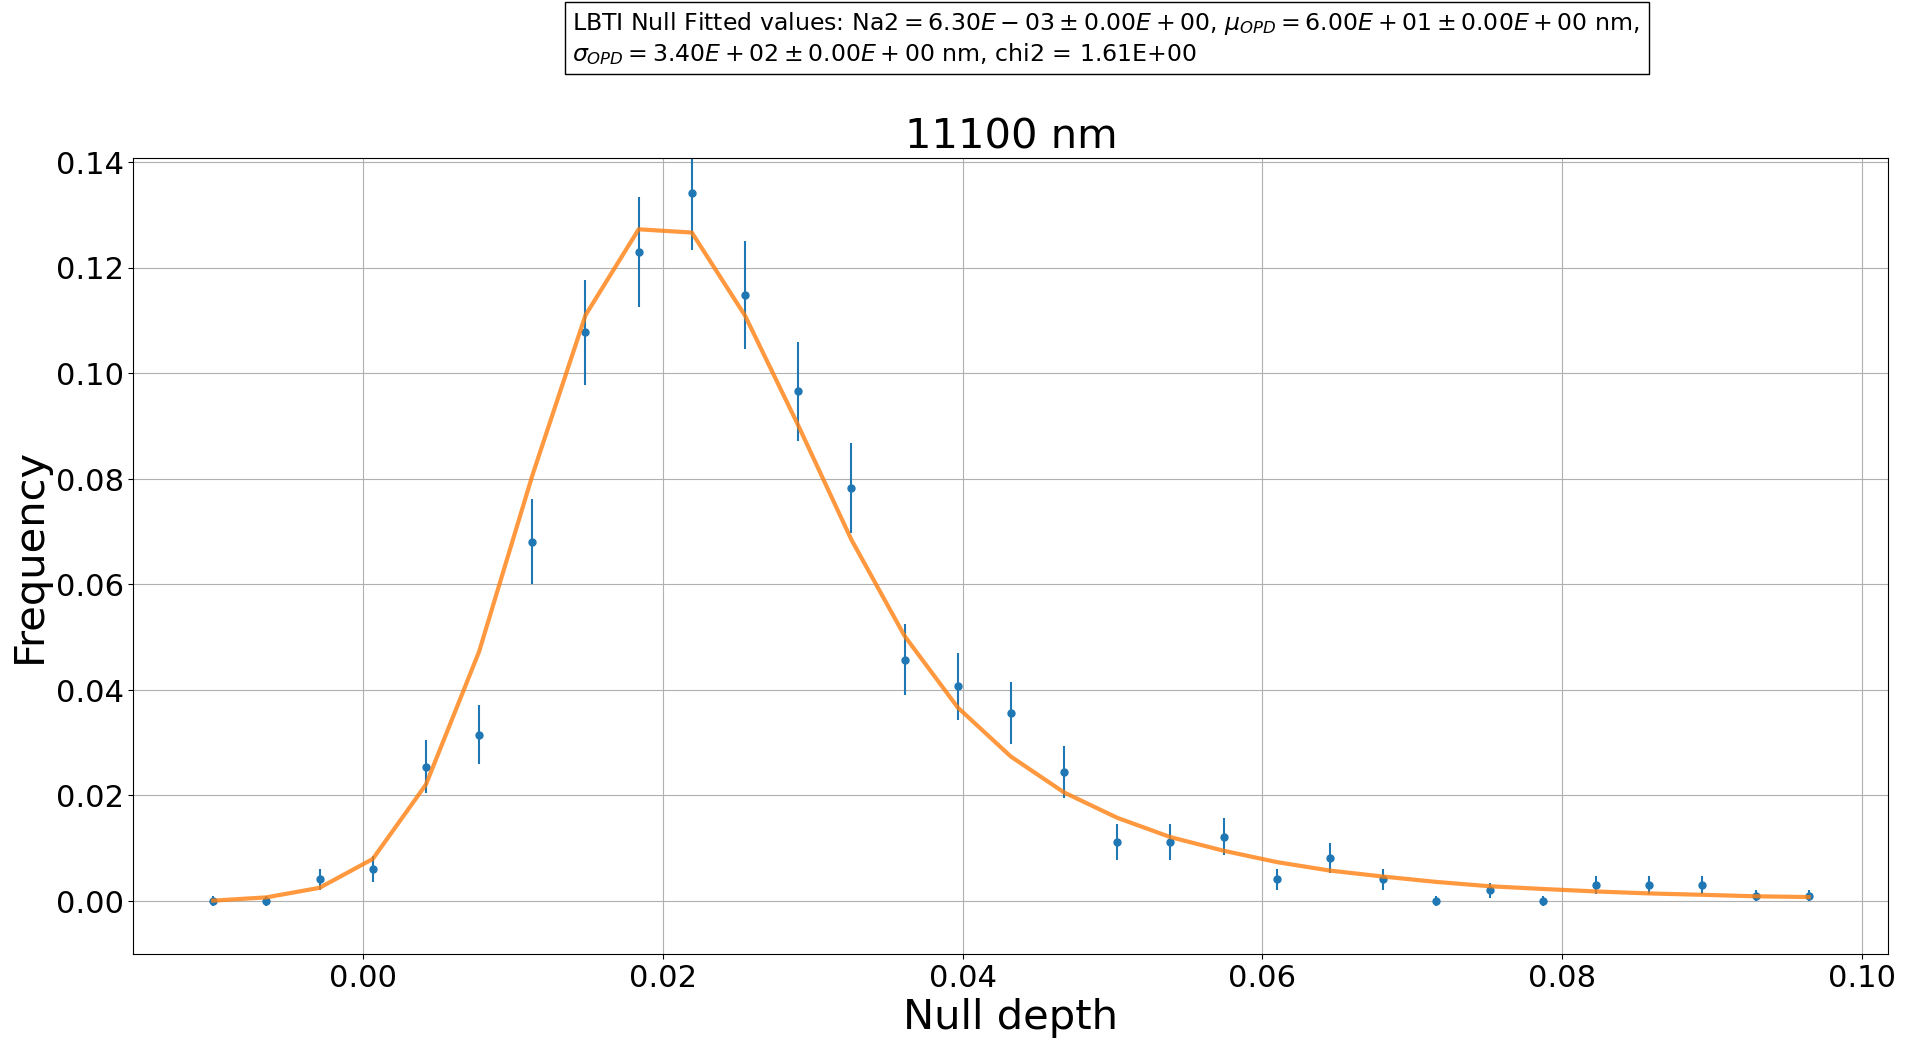

In [4]:
import h5py
import numpy as np
import os

datafolder = 'dataset/'
darkfolder = datafolder
save_path = 'results/'

import grip
try:
    import cupy as cp # To use the GPU to speed up the process
except ModuleNotFoundError:
    import numpy as cp # If no GPU, we load numpy again with the same acronym to still use the functions


wl_min, wl_max = 11000, 11200
dark_list = ['dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5']
data_list = ['dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5']
dark = grip.load_data(dark_list, ['wl_scale', 'Iminus1', 'p1', 'p2'], (wl_min, wl_max))
data = grip.load_data(data_list, ['wl_scale', 'Iminus1', 'p1', 'p2', 'intraphase_rms'], (wl_min, wl_max))

wl_scale = data['wl_scale']
dark_IA, dark_IB = dark['p1'], dark['p2']
dark_Iminus = dark['Iminus1']
Iminus = data['Iminus1']
data_IA, data_IB = data['p1'], data['p2']

# Calculate the null depth
Iplus = data_IA + data_IB + 2 * (data_IA * data_IB)**0.5 # Using the estimator above
data_null = Iminus / Iplus # Calculated null depth

# Get the histogram
bin_bounds = (-0.01, 0.1) # Minimum and maximum values of the bins of the histogram
normed=True # We want to normalise the histogram by its sum

null_axis, null_pdf, null_pdf_err, sz = grip.compute_data_histogram(data_null, \
                                                          bin_bounds, \
                                           wl_scale, normed=normed)

injection, spectra = grip.get_injection_and_spectrum(
    data_IA, data_IB, wl_scale, (wl_min, wl_max))
nb_frames_binning_photometry = -1 # Bin over all the sample
injection, dummy = grip.binning(
    injection, nb_frames_binning_photometry, axis=1, avg=True)


data_IA_axis = cp.linspace(injection[0].min(), injection[0].max(),
                           np.size(np.unique(injection[0])),
                           dtype=cp.float32)
cdf_data_IA = grip.computeCdf(data_IA_axis, injection[0], 'cdf', True)
cdf_data_IA = cp.array(cdf_data_IA, dtype=cp.float32)

data_IB_axis = cp.linspace(injection[1].min(), injection[1].max(),
                           np.size(np.unique(injection[1])),
                           dtype=cp.float32)
cdf_data_IB = grip.computeCdf(data_IB_axis, injection[1], 'cdf', True)
cdf_data_IB = cp.array(cdf_data_IB, dtype=cp.float32)

sigma_eps = data['intraphase_rms']
sigma_eps = np.radians(sigma_eps)
sigma_eps *= 2200 / wl_scale
sigma_eps = sigma_eps.reshape((1, -1))
sigma_eps_axis, sigma_eps_cdf = grip.get_dark_cdf(sigma_eps, wl_scale)

std_dark_Iminus = np.std(dark_Iminus)
dark_Iminus -= np.mean(dark_Iminus, 1, keepdims=True) # The model is better when the data are forced to be of average 0
    
dark_Iminus_axis, dark_Iminus_cdf = grip.get_dark_cdf(
    dark_Iminus, wl_scale)

rvu_opd = None # To generate RV reproducing the statistics of the OPD fluctuations
rvu_IA = None # To generate RV reproducing the statistics of the injection of beam A
rvu_IB = None # To generate RV reproducing the statistics of the injection of beam B
rvu_bg = [None]*wl_scale.size # To generate RV reproducing the statistics of the thermal background, per spectral channel
rvu_eps = [None]*wl_scale.size # To generate RV reproducing the statistics of the fringe blurring, per spectral channel

# Embed all of the above in lists
rvus = [rvu_IA, rvu_IB, rvu_bg, rvu_eps]
cdfs = [(data_IA_axis, cdf_data_IA), (data_IB_axis, cdf_data_IB),\
        (dark_Iminus_axis, dark_Iminus_cdf), (sigma_eps_axis, sigma_eps_cdf)]

n_samp_total = int(1e6)
n_samp_per_loop = int(1e6)
nloop = n_samp_total // n_samp_per_loop

na = 0.0063
mu_opd = 60 # in nm
sig_opd = 340 # in nm
initial_guess = [na, mu_opd, sig_opd]
initial_guess = np.array(initial_guess, dtype=np.float64)
spec_chan_width = 2600

instrument_constants = (spec_chan_width,) # Constant of the model: the spectral width of the instrument and the pi phase used to get the null fringe
out = grip.create_histogram_model(initial_guess, null_axis, wl_scale, my_lbti_model, instrument_constants, rvu_opd, cdfs, rvus, \
                                  n_samp_per_loop=n_samp_per_loop, nloop=nloop)

synth_histo = out[0] # Flatten histogram along the wavelength axis.
diag = out[1][0]
diag = cp.array(diag)
diag = cp.asnumpy(diag)
diag_opd = cp.asnumpy(cp.array(out[2][0][0][0]))
diag_IA = cp.asnumpy(cp.array(out[2][0][0][1]))
diag_IB = cp.asnumpy(cp.array(out[2][0][0][2]))
diag_dkIA = cp.asnumpy(cp.array(out[3])[0,:,0])
diag_dkIB = cp.asnumpy(cp.array(out[3])[0,:,1])

uncertainties = np.zeros(3)
popt = (np.array([na, mu_opd, sig_opd]), np.ones((3, 3)))
extra_args = [null_pdf_err]
chi2 = grip.calculate_chi2(popt[0], null_pdf, grip.create_histogram_model, *extra_args, use_this_model=synth_histo)
print(chi2)

nb_rows_plot = 3
label_optimizer = 'chi2'
key = 'LBTI Null'
text_params = '%s ' % key+'Fitted values: ' +\
    'Na2$ = %.2E \pm %.2E$, ' % (na,
                                uncertainties[0]) +\
    r'$\mu_{OPD} = %.2E \pm %.2E$ nm, ' % (popt[0][1],
                                            uncertainties[1]) +\
    '\n' + r'$\sigma_{OPD} = %.2E \pm %.2E$ nm,' % (
        popt[0][2], uncertainties[2]) +\
    ' '+label_optimizer+' = %.2E ' % (chi2)
    
save_name = key + '_' + str(wl_min) + '-' + str(wl_max) + '_' + os.path.basename(datafolder[:-1])
grip.plot_null_distributions(nb_rows_plot, wl_scale, text_params, null_axis, null_pdf,\
                            null_pdf_err, save_path, save_name, model=synth_histo,\
                                save_fig=False)

It works!

And this model is not a copy/paste of the model pre-made in GRIP, there is one argument less in `instrument_constants`.

### Congratulations, we know how to design our own model with GRIP